In [3]:
import yahoo_fin
from yahoo_fin.stock_info import get_data
import requests
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import date
from scipy.stats import norm
import datetime
%matplotlib inline

Warning - Certain functionality 
             requires requests_html, which is not installed.
             
             Install using: 
             pip install requests_html
             
             After installation, you may have to restart your Python session.


In [4]:
start = '01/01/2018'
#end = '09/22/2022'
today = date.today()
end = today.strftime("%m/%d/%y")

In [5]:
def stock_data(x, start, end):
    df = get_data(x, start_date = start, end_date = end, index_as_date = True, interval = '1d')
    df.reset_index(inplace = True)
    df = df.rename(columns = {df.columns[0]:'date'})
    df = df.drop(columns = {'ticker'})
    return df

In [6]:
 def visualise_data(df):
    # Plot the data
    plt.figure(figsize = (14, 7))
    plt.plot(df['date'], df['close'], label = 'Close Price')
    plt.title('Stock Closing Price')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.show()

In [7]:
def SMA(df, n):
    return df.rolling(n).mean()

In [44]:
def comprehensive_data(stock, period, start, end):
    # Get stock data
    df = stock_data(stock, start, end)
    
#     # Calculate VWMA
#     temp = df['close'] * df['volume']
#     VWMA = [None] * (period - 1)
#     accumulator = sum(temp[:period])
    
#     VWMA.append(accumulator / sum(df['volume'][:period]))
    
#     for i in range(1, len(temp) - period + 1):
#         accumulator = accumulator - temp[i - 1] + temp[i + period - 1]
#         VWMA.append(accumulator / sum(df['volume'][i:i + period]))
    
#     df['VWMA'] = VWMA
#     df = df.dropna(subset = ['VWMA'])

    # Calculate SMA
    temp = SMA(df['close'], period)
    df['SMA'] = temp

    # Calculate change from yesterday
    
    
    # Calculate change and % change from previous day
    # Change and % change from previous day
    df['temp'] = df['close'].shift(periods = 1) 
    df['change'] = df['close'] - df['temp']

    # So no NaNs in the VWMA or SMA column
    # df = df.dropna(subset = ['temp', 'VWMA'])
    df = df.dropna(subset = ['temp', 'SMA'])
    
    # Calculate deviation from SMA
    df['deviation'] = df['close'] - df['SMA']
    
    df = df.drop(columns = ['adjclose', 'high', 'low'])
    return df

In [45]:
comprehensive_data('AUDUSD=X', 25, start, today)

,date,open,close,volume,SMA,temp,change,deviation
24,2018-02-02,0.804117,0.804052,0.0,0.794850,0.806127,-0.002074,0.009203
25,2018-02-05,0.790670,0.790639,0.0,0.795267,0.804052,-0.013414,-0.004628
26,2018-02-06,0.787637,0.787464,0.0,0.795561,0.790639,-0.003175,-0.008097
27,2018-02-07,0.789278,0.789391,0.0,0.795801,0.787464,0.001927,-0.006410
28,2018-02-08,0.781739,0.781739,0.0,0.795757,0.789391,-0.007652,-0.014018
...,...,...,...,...,...,...,...,...
1742,2024-09-03,0.671400,0.671400,0.0,0.665976,0.678730,-0.007330,0.005424
1743,2024-09-04,0.671619,0.671619,0.0,0.666653,0.671400,0.000219,0.004966
1744,2024-09-05,0.674050,0.674050,0.0,0.667636,0.671619,0.002431,0.006415
1745,2024-09-08,0.667080,0.667080,0.0,0.668330,0.674050,-0.006970,-0.001250


In [10]:
# Get df for a stock
# Need to run before next part
data = comprehensive_data('AUDUSD=X', 100, start, today)
data = data.drop(columns = ['volume'])

In [11]:
def distribution(df, threshold):
    # Calculate distribution of devia_tion from MA / % cha_nge
    # Replace devia_tion <-> cha_nge
    mean = np.mean(df['deviation'])
    std = np.std(df['deviation'])
     
    # Calculate the z-score threshold
    # This is for 90% CI
#     z_threshold = 1.645
    # This is for 95% CI
    z_threshold = 1.96
    # This is for 99% CI
#     z_threshold = 2.576
    
    
    # Calculate the actual value thresholds
    lower_threshold = mean - z_threshold * std
    upper_threshold = mean + z_threshold * std
    
    # Identify outliers
    outliers = df[(df['deviation'] < lower_threshold) | (df['deviation'] > upper_threshold)]

    # Plot histogram
    plt.figure(figsize=(10, 6))
    count, bins, ignored = plt.hist(df['deviation'], bins = 100, density = True, alpha = 0.6, color = 	"#4DBEEE")

    # Plot the normal distribution curve
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mean, std)
    plt.plot(x, p, 'k', linewidth = 1)
    title = "Distribution of Daily deviation"
    plt.title(title)

    plt.show()
    
    return outliers

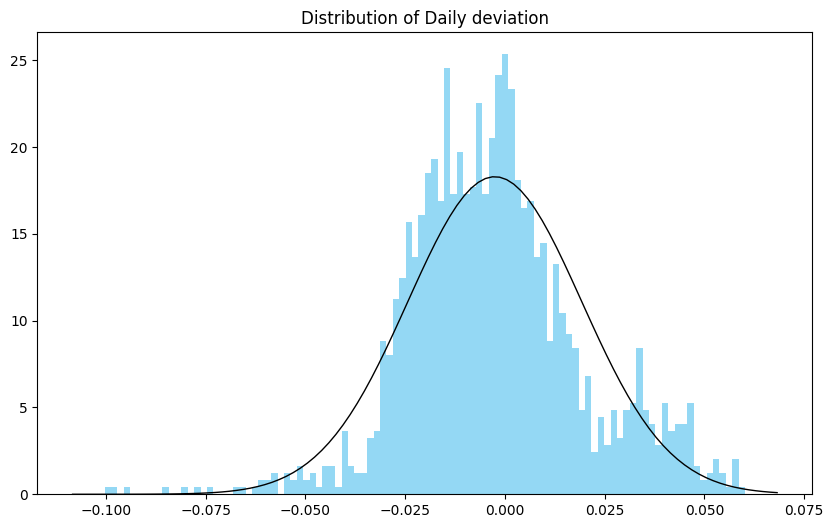

,date,open,close,SMA,temp,change,deviation
574,2020-03-13,0.628210,0.627412,0.679126,0.647940,-0.020528,-0.051715
575,2020-03-16,0.617871,0.617768,0.678480,0.627412,-0.009643,-0.060712
576,2020-03-17,0.610450,0.609942,0.677740,0.617768,-0.007826,-0.067798
577,2020-03-18,0.598830,0.599220,0.676876,0.609942,-0.010722,-0.077656
578,2020-03-19,0.579950,0.580980,0.675788,0.599220,-0.018240,-0.094808
...,...,...,...,...,...,...,...
1323,2023-01-26,0.710820,0.710820,0.665156,0.704672,0.006148,0.045664
1324,2023-01-27,0.711390,0.711390,0.665504,0.710820,0.000570,0.045886
1325,2023-01-30,0.710798,0.710798,0.665765,0.711390,-0.000592,0.045033
1328,2023-02-02,0.714500,0.714500,0.666630,0.705140,0.009360,0.047870


In [12]:
distribution(data, 1)

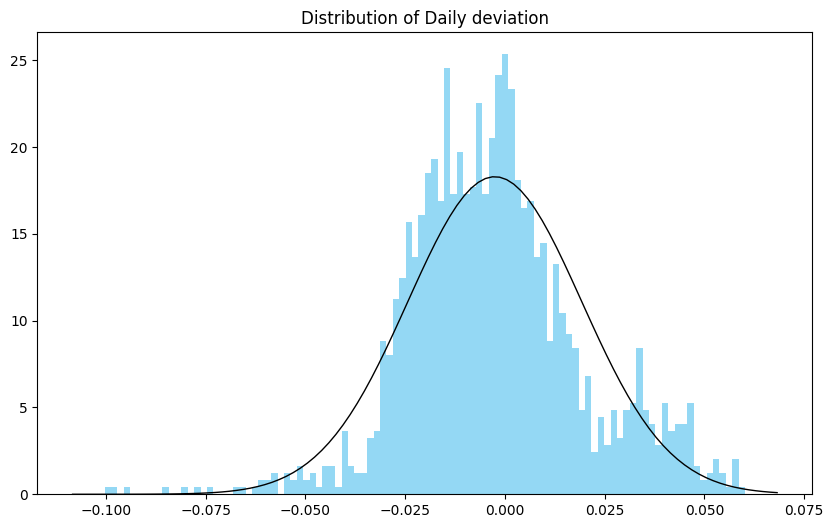

In [13]:
outlier_dates = distribution(data, 1)['date']

In [14]:
for date in outlier_dates:
    print(date)

2020-03-13 00:00:00
2020-03-16 00:00:00
2020-03-17 00:00:00
2020-03-18 00:00:00
2020-03-19 00:00:00
2020-03-20 00:00:00
2020-03-23 00:00:00
2020-03-24 00:00:00
2020-03-25 00:00:00
2020-03-26 00:00:00
2020-03-27 00:00:00
2020-03-29 00:00:00
2020-03-30 00:00:00
2020-03-31 00:00:00
2020-04-01 00:00:00
2020-04-02 00:00:00
2020-04-05 00:00:00
2020-04-06 00:00:00
2020-04-07 00:00:00
2020-06-02 00:00:00
2020-06-03 00:00:00
2020-06-04 00:00:00
2020-06-07 00:00:00
2020-06-08 00:00:00
2020-06-09 00:00:00
2020-06-10 00:00:00
2020-06-15 00:00:00
2020-06-16 00:00:00
2020-06-22 00:00:00
2020-06-23 00:00:00
2020-07-01 00:00:00
2020-07-02 00:00:00
2020-07-05 00:00:00
2020-07-06 00:00:00
2020-07-07 00:00:00
2020-07-08 00:00:00
2020-07-09 00:00:00
2020-07-12 00:00:00
2020-07-13 00:00:00
2020-07-14 00:00:00
2020-07-15 00:00:00
2020-07-16 00:00:00
2020-07-19 00:00:00
2020-07-20 00:00:00
2020-07-21 00:00:00
2020-07-22 00:00:00
2020-07-23 00:00:00
2020-07-26 00:00:00
2020-07-27 00:00:00
2020-07-28 00:00:00


In [28]:
def trade_after_outlier(outlier_dates, stock, period, days_after = 30):
    trade_summary = []
    previous_date = outlier_dates.min() - datetime.timedelta(days = 21)
    filtered_dates = []
    
    for date in outlier_dates:
        if (date - previous_date).days > 10:
            filtered_dates.append(date)
            previous_date = date
            
    # Fetch stock data
    data = comprehensive_data(stock, period, start, today)
    
    for date in filtered_dates:
        start_date = date - datetime.timedelta(days = 0)
        end_date = date + datetime.timedelta(days = days_after)
        
        # Create temporary df with the date ranges
        temp = data[(data['date'] >= start_date) & (data['date'] <= end_date)]

        # Plot cumulative returns
        entry_price = temp.loc[temp['open'].first_valid_index(), 'open']

        temp['cum_returns'] = temp['close'] - entry_price
        temp = temp.drop(columns = ['temp'])
        temp = temp.dropna()
        temp['above_SMA'] = (temp['deviation'] >= 0).astype(int)

        # Plot the data
        plt.figure(figsize = (10, 6))
        # Plot close against SMA
        # plt.plot(data[(data['date'] >= start_date) & (data['date'] <= end_date)]['date'], data[(data['date'] >= start_date) & (data['date'] <= end_date)]['close'], label = 'Close Price')
        # plt.plot(data[(data['date'] >= start_date) & (data['date'] <= end_date)]['date'], data[(data['date'] >= start_date) & (data['date'] <= end_date)]['SMA'], label = 'SMA')

        # Plot deviation from SMA and cum_returns
        plt.plot(temp['date'], temp['deviation'], label = 'Deviation from SMA')
        plt.plot(temp['date'], temp['cum_returns'], label = 'cum_returns')

        plt.title(f'Security Movement after shock {date}')
        plt.xticks(rotation = 45)
        plt.xlabel('Date')
        plt.ylabel('Close Price')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Finding the cumulative return for the period
        trade_entry = temp['date'].min().strftime('%d-%m-%Y')
        trade_exit = temp['date'].max().strftime('%d-%m-%Y')
        cum_return = temp.loc[temp['cum_returns'].last_valid_index(), 'cum_returns']
        perc_return = (100 * cum_return) / entry_price
        above_SMA = temp.loc[temp['above_SMA'].first_valid_index(), 'above_SMA']

        trade_summary.append([trade_entry, trade_exit, cum_return, perc_return, above_SMA])

    df = pd.DataFrame(trade_summary, columns = ['entry_date', 'exit_date', 'change', 'perc_change', 'above_SMA'])
    df['trade_return'] = df.apply(lambda row: row['perc_change'] if row['above_SMA'] == 0 else -row['perc_change'], axis = 1)
    df['trade_return'] = df['trade_return'] / 100  # Convert percentage to decimal

    # Step 1: Calculate cumulative return
    df['cumulative_return'] = (1 + df['trade_return']).cumprod()
    return df
    


In [43]:
security = '883'
x = trade_after_outlier(outlier_dates, security, 50, days_after = 100)
trade_after_outlier(outlier_dates, security, 50, days_after = 100)

AssertionError: {'chart': {'result': None, 'error': {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}}}

In [42]:
x['trade_return'].sum()

-0.4265884836239152

In [33]:
def backtest(df, initial_capital = 10000):
    df['Return'] = df['Close'].pct_change()
    df['Strategy Return'] = df['Return'] * df['Signal'].shift(1)
    df['Equity'] = (1 + df['Strategy Return'].fillna(0)).cumprod() * initial_capital
    df['Drawdown'] = (df['Equity'] - df['Equity'].cummax()) / df['Equity'].cummax()
    
    total_return = (df['Equity'].iloc[-1] - initial_capital) / initial_capital
    strategy_return_std = df['Strategy Return'].std()
    if strategy_return_std != 0:
        sharpe_ratio = np.sqrt(252) * df['Strategy Return'].mean() / strategy_return_std
    else:
        sharpe_ratio = np.nan
    
    max_drawdown = df['Drawdown'].min()
    
    return df, {
        'Total Return': total_return,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown
    }